In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, plot_graphs, plot_mnist
import numpy as np
from IPython.core.debugger import set_trace

%matplotlib inline

In [27]:
train_loader, valid_loader, test_loader = mnist(valid=10000)

In [28]:
class Encoder(nn.Module):
    def __init__(self, latent_size=10):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(28*28, latent_size)
    
    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))
        return x
    
class Decoder(nn.Module):
    def __init__(self, latent_size=10):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_size, 28*28)
    
    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        return x

In [29]:
class Net(nn.Module):
    def __init__(self, latent_size=10, loss_fn=F.mse_loss, lr=1e-4, l2=0., sparse_fn = None, noise = False):
        super(Net, self).__init__()
        self.latent_size = latent_size
        self.E = Encoder(latent_size)
        self.D = Decoder(latent_size)
        self.loss_fn = loss_fn
        self._rho_loss = None
        self._loss = None
        self._sparse_fn = sparse_fn
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        self._noise = noise
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        if (self._noise):
            x = (x + 0.5*torch.randn(28*28)).clamp(-1, 1)
        h = self.E(x)
        self.data_rho = h.mean(0)
        out = self.D(h)
        return out
    
    def decode(self, h):
        with torch.no_grad():
            return self.D(h)
    
    def rho_loss(self, rho, size_average=True):
        
        if (self._sparse_fn is not None):
            dkl = self._sparse_fn(rho, self.data_rho)
        else:
            dkl = torch.zeros(self.latent_size);
        if size_average:
            self._rho_loss = dkl.mean()
        else:
            self._rho_loss = dkl.sum()
        return self._rho_loss
    
    def loss(self, x, target, **kwargs):
        target = target.view(-1, 28*28)
        self._loss = self.loss_fn(x, target, **kwargs)
        return self._loss

In [30]:
def sparse_fn1(rho, data_rho):
    return - torch.log(data_rho/rho) * rho - torch.log((1-data_rho)/(1-rho)) * (1-rho)

def sparse_fn2(rho, data_rho):
    return - torch.log(data_rho) * rho - torch.log(1 - data_rho) * (1-rho)

models = {
    '64': Net(64),
    '64_N': Net(64, noise = True),
    '64_S1': Net(64, sparse_fn = sparse_fn1),
    '64_S2': Net(64, sparse_fn = sparse_fn2),
}
rho = 0.05
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [31]:
def train(epoch, models, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, _) in enumerate(train_loader):
        for model in models.values():
            model.optim.zero_grad()
            output = model(data)
            rho_loss = model.rho_loss(rho)
            loss = model.loss(output, data) + rho_loss
            loss.backward()
            model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append((models[k]._loss, models[k]._rho_loss))
        print(line + losses)

In [32]:
avg_lambda = lambda l: 'loss: {:.4f}'.format(l)
rho_lambda = lambda p: 'rho_loss: {:.4f}'.format(p)
line = lambda i, l, p: '{}: '.format(i) + avg_lambda(l) + '\t' + rho_lambda(p)
    
def test(models, loader, log=None):
    test_size = len(loader.sampler)

    test_loss = {k: 0. for k in models}
    rho_loss = {k: 0. for k in models}
    with torch.no_grad():
        for data, _ in loader:
            output = {k: m(data) for k, m in models.items()}
            for k, m in models.items():
                test_loss[k] += m.loss(output[k], data, reduction='sum').item() # sum up batch loss
                rho_loss[k] += m.rho_loss(rho, size_average=False).item()
    
    for k in models:
        test_loss[k] /= (test_size * 784)
        rho_loss[k] /= (test_size * models[k].latent_size)
        if log is not None:
            log[k].append((test_loss[k], rho_loss[k]))
    
    lines = '\n'.join([line(k, test_loss[k], rho_loss[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines        
    print(report)

In [33]:
for epoch in range(1, 26):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, valid_loader, test_log)

Train Epoch: 1 [0/50000 (0%)]	Losses 64: 1.129795 64_N: 1.109481 64_S1: 1.137556 64_S2: 1.112466
Train Epoch: 1 [10000/50000 (20%)]	Losses 64: 0.714538 64_N: 0.720677 64_S1: 0.926163 64_S2: 0.919733
Train Epoch: 1 [20000/50000 (40%)]	Losses 64: 0.664989 64_N: 0.682332 64_S1: 0.848707 64_S2: 0.840198
Train Epoch: 1 [30000/50000 (60%)]	Losses 64: 0.657499 64_N: 0.681963 64_S1: 0.792791 64_S2: 0.787748
Train Epoch: 1 [40000/50000 (80%)]	Losses 64: 0.620025 64_N: 0.647971 64_S1: 0.712359 64_S2: 0.710706
Train Epoch: 1 [50000/50000 (100%)]	Losses 64: 0.638279 64_N: 0.670662 64_S1: 0.722994 64_S2: 0.721935
Test set:
64: loss: 0.6055	rho_loss: 0.0000
64_N: loss: 0.6331	rho_loss: 0.0000
64_S1: loss: 0.6831	rho_loss: 0.0010
64_S2: loss: 0.6859	rho_loss: 0.0050

Train Epoch: 2 [0/50000 (0%)]	Losses 64: 0.596860 64_N: 0.625049 64_S1: 0.669330 64_S2: 0.674057
Train Epoch: 2 [10000/50000 (20%)]	Losses 64: 0.580560 64_N: 0.602158 64_S1: 0.642386 64_S2: 0.648539
Train Epoch: 2 [20000/50000 (40%)]	Los

In [48]:
data, _ = next(iter(test_loader))
# Прогон
output64 = models['64'](data)
output64_s1 = models['64_S1'](data)
output64_s2 = models['64_S2'](data)
# Выход из нейросети нарпямую
to_plot_1 = output64.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()
to_plot_2 = output64_s1.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()
to_plot_3 = output64_s2.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()

# Декодирование по набору где на одном нейроне полный сигнал - 1, а на отсальных  - 0.
#decoded = models['128'].decode(torch.eye(128))
# выравнивание от -1-1, 0-1
#dec_to_plot = ((decoded.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy()

# добавленеи шума на сжатое представление
#with torch.no_grad():
 #   encoded = models['128'].E(data.view(-1, 28*28))
  #  print((encoded > 0.2).sum(1))
    # как раз сам шум
   # encoded[encoded < 0.2] = 0.
    #f_to_plot = ((decoded_f.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy()
    
noised = (data + 0.5 * torch.randn(data.shape)).clamp(-1, 1)
output64_n = models['64_N'](noised)
output64_dn = models['64'](noised)
to_plot_n = output64_n.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()
to_plot_dn = output64_dn.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()

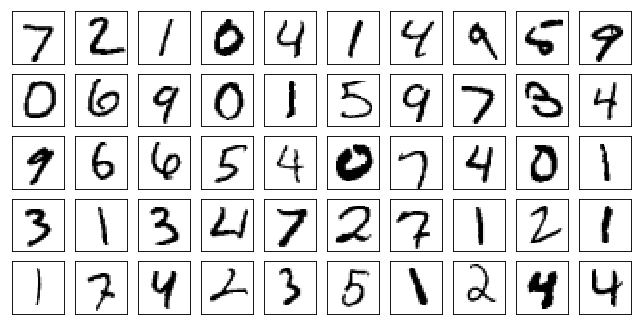

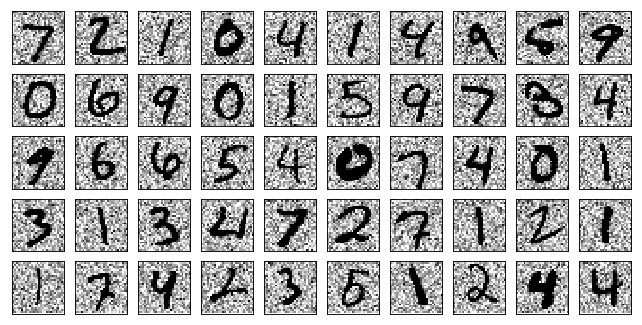

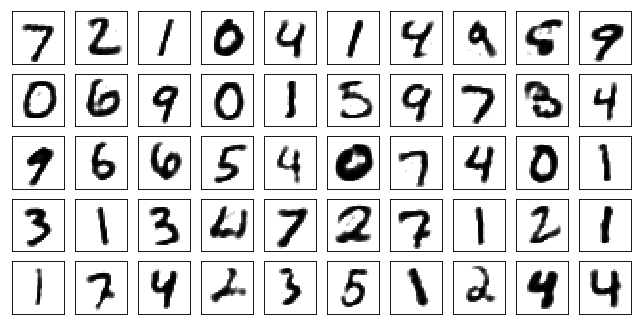

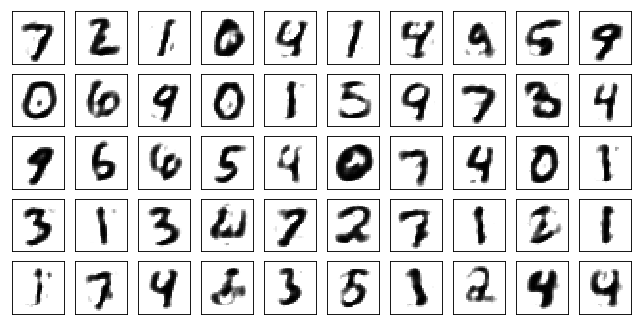

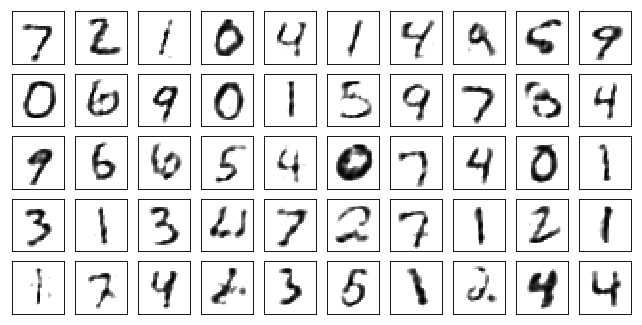

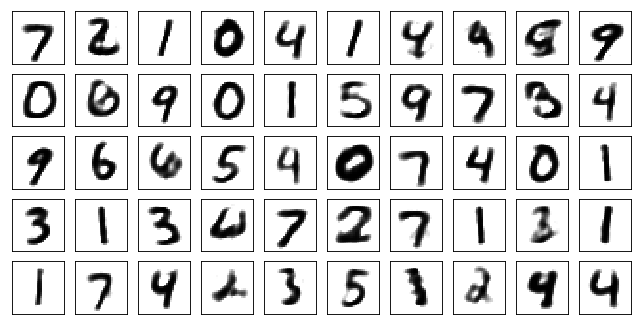

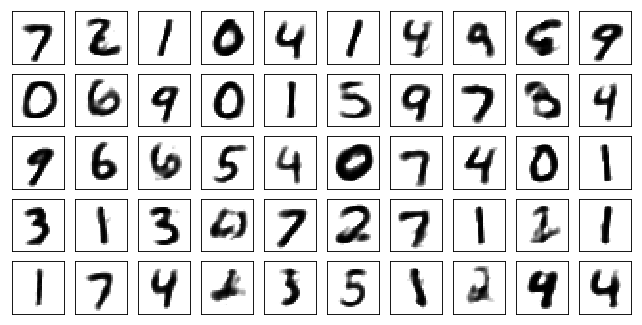

In [49]:
plot_mnist(data.data.numpy(), (5, 10))
plot_mnist(noised.data.numpy(), (5, 10))
plot_mnist(to_plot_1, (5, 10))
plot_mnist(to_plot_n, (5, 10))
plot_mnist(to_plot_dn, (5, 10))
plot_mnist(to_plot_2, (5, 10))
plot_mnist(to_plot_3, (5, 10))
#plot_mnist(f_to_plot, (5, 10))
#plot_mnist(dec_to_plot, (16, 8))